# Advanced RAG on Hugging Face documentation using LangChain

## Import

In [22]:
# Use faiss-gpu-cu12 or faiss-gpu-cu11 accroding to your CUDA version instead of faiss-gpu
!pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers openpyxl pacmap datasets langchain-community ragatouille matplotlib faiss-gpu-cu12

In [2]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

# This will be helpful when visualizing retriever outputs
pd.set_option("display.max_colwidth", None)

### Load your knowledge base

In [3]:
import datasets

ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

In [4]:
# In my case, I needed to update jupyter : !pip install -U jupyter 

In [5]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in tqdm(ds)
]

  0%|          | 0/2647 [00:00<?, ?it/s]

## 1. Retriever - embeddings

### 1.1 Split the documents into chunks

In [13]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
    add_start_index=True,
    strip_whitespace=True,
    separators=MARKDOWN_SEPARATORS,
)

doc_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    doc_processed += text_splitter.split_documents([doc])

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 512


  0%|          | 0/31085 [00:00<?, ?it/s]

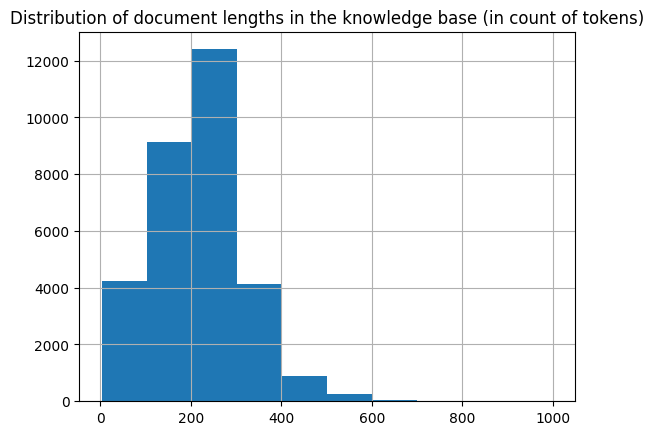

In [19]:
from sentence_transformers import SentenceTransformer

print(f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}")

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(doc_processed)]

fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()